## Enhanced Model 2

In [1]:
# # 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
# !pip install transformers
# !pip install ipywidgets

# # matplotlib에 한글 폰트가 나오도록 설치
# !pip install koreanize-matplotlib

# # 기존 설치된 pytorch cpu 버전을 제거 후 cuda로 설치
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score 

ROOT = Path("/mnt/elice/dataset")

In [3]:
import torch # 파이토치 
import random
import numpy as np
import pandas as pd
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

### GPU 장비 설정

In [4]:
!nvidia-smi

Mon Aug 18 01:23:06 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:65:00.0 Off |                   On |
| N/A   40C    P0              48W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

In [6]:
!pwd

/home/elicer


In [7]:
!ls /mnt/elice/dataset

'제출용 데이터'		 'TS_도막 손상_도막떨어짐'   TS_양품_선수
'TS_도장 불량_부풀음'	 'TS_도장 불량_이물질포함'
'TS_도막 손상_스크래치'   TS_양품_외판


In [8]:
# !ls /mnt/elice/dataset/'TS_양품_선수'

In [9]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품",
    "TS_양품_외판": "양품",
}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (128, 128)

In [10]:
X, y = [], []
for folder, label in folder_to_label.items():
    d = ROOT / folder
    for p in d.rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            im = Image.open(p).convert("L").resize(IMG_SIZE)
            arr = np.array(im, dtype=np.float32) / 255.0
            X.append(arr)#.ravel()) # flatten 하지 않고 128, 128 행렬 형태로 저장
            y.append(label)

### 타깃값 분포

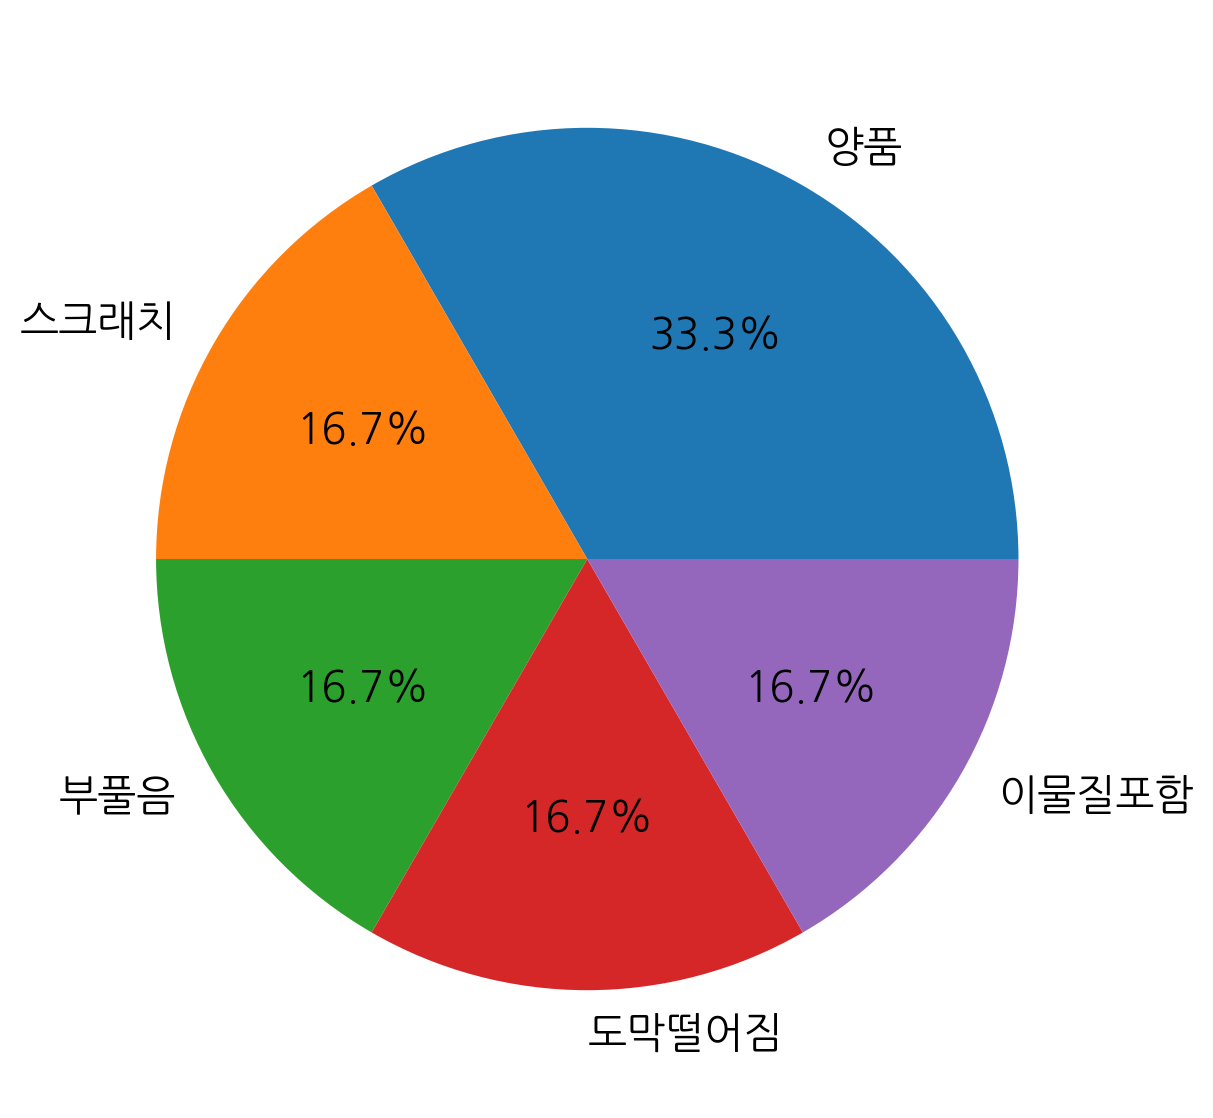

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib 사용 시 한글 폰트가 나오도록
import koreanize_matplotlib
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# 타깃값 분포 파이 그래프
plt.pie(pd.Series(y).value_counts(), labels=pd.Series(y).value_counts().index, autopct='%.1f%%');

### 이미지 출력

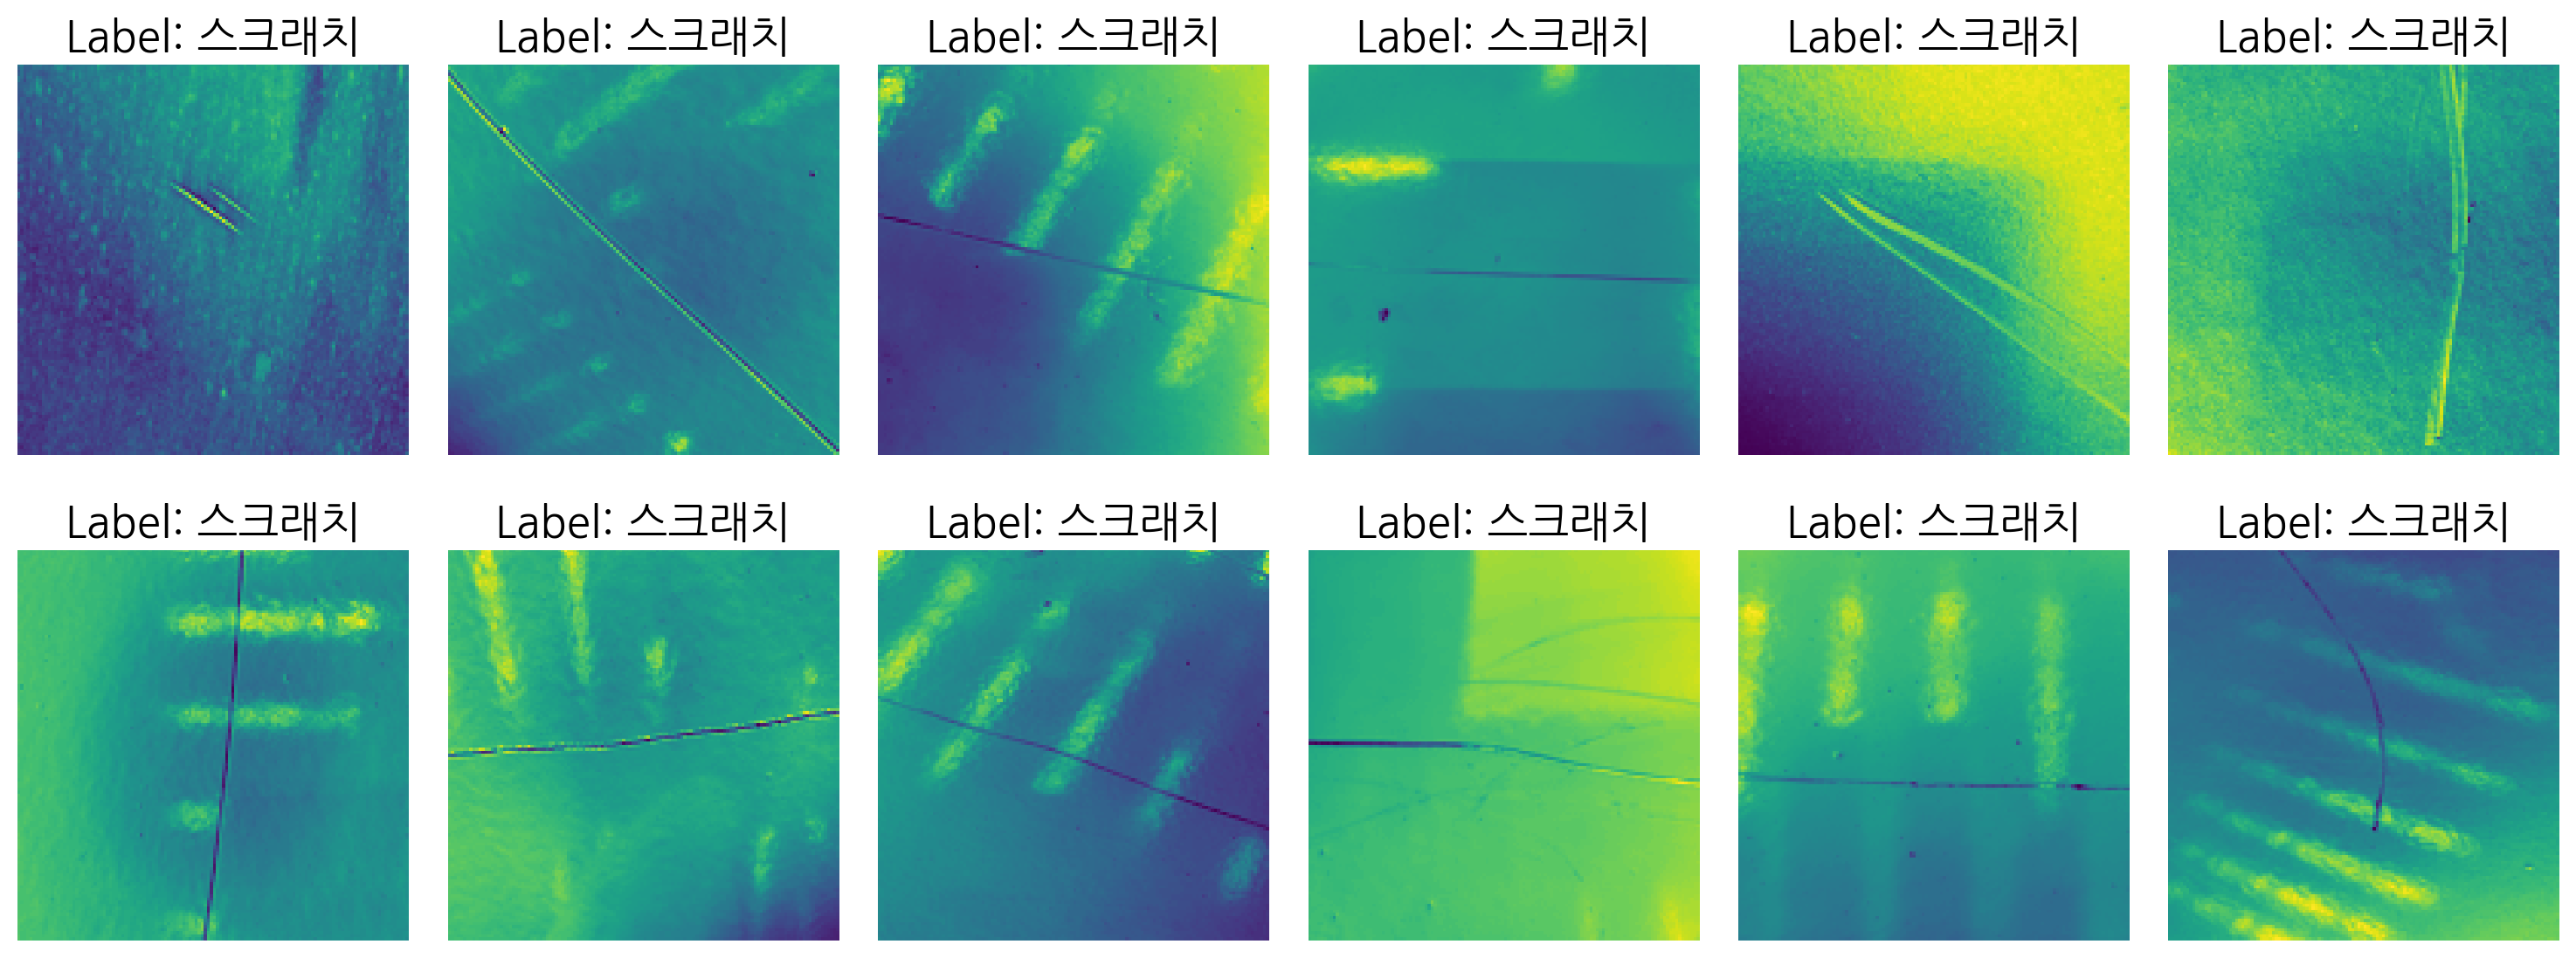

In [12]:
import matplotlib.gridspec as gridspec

# 이미지 및 라벨 확인
plt.rcParams['font.size'] = 15
plt.figure(figsize=(15, 6))  # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 2행 6열로 서브플롯 배치

# 12개의 이미지 출력 (X와 y의 길이가 12라고 가정)
for idx, (image_data, label) in enumerate(zip(X[:12], y[:12])):
    ax = plt.subplot(grid[idx])
    ax.imshow(image_data)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # 축 정보 숨기기

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

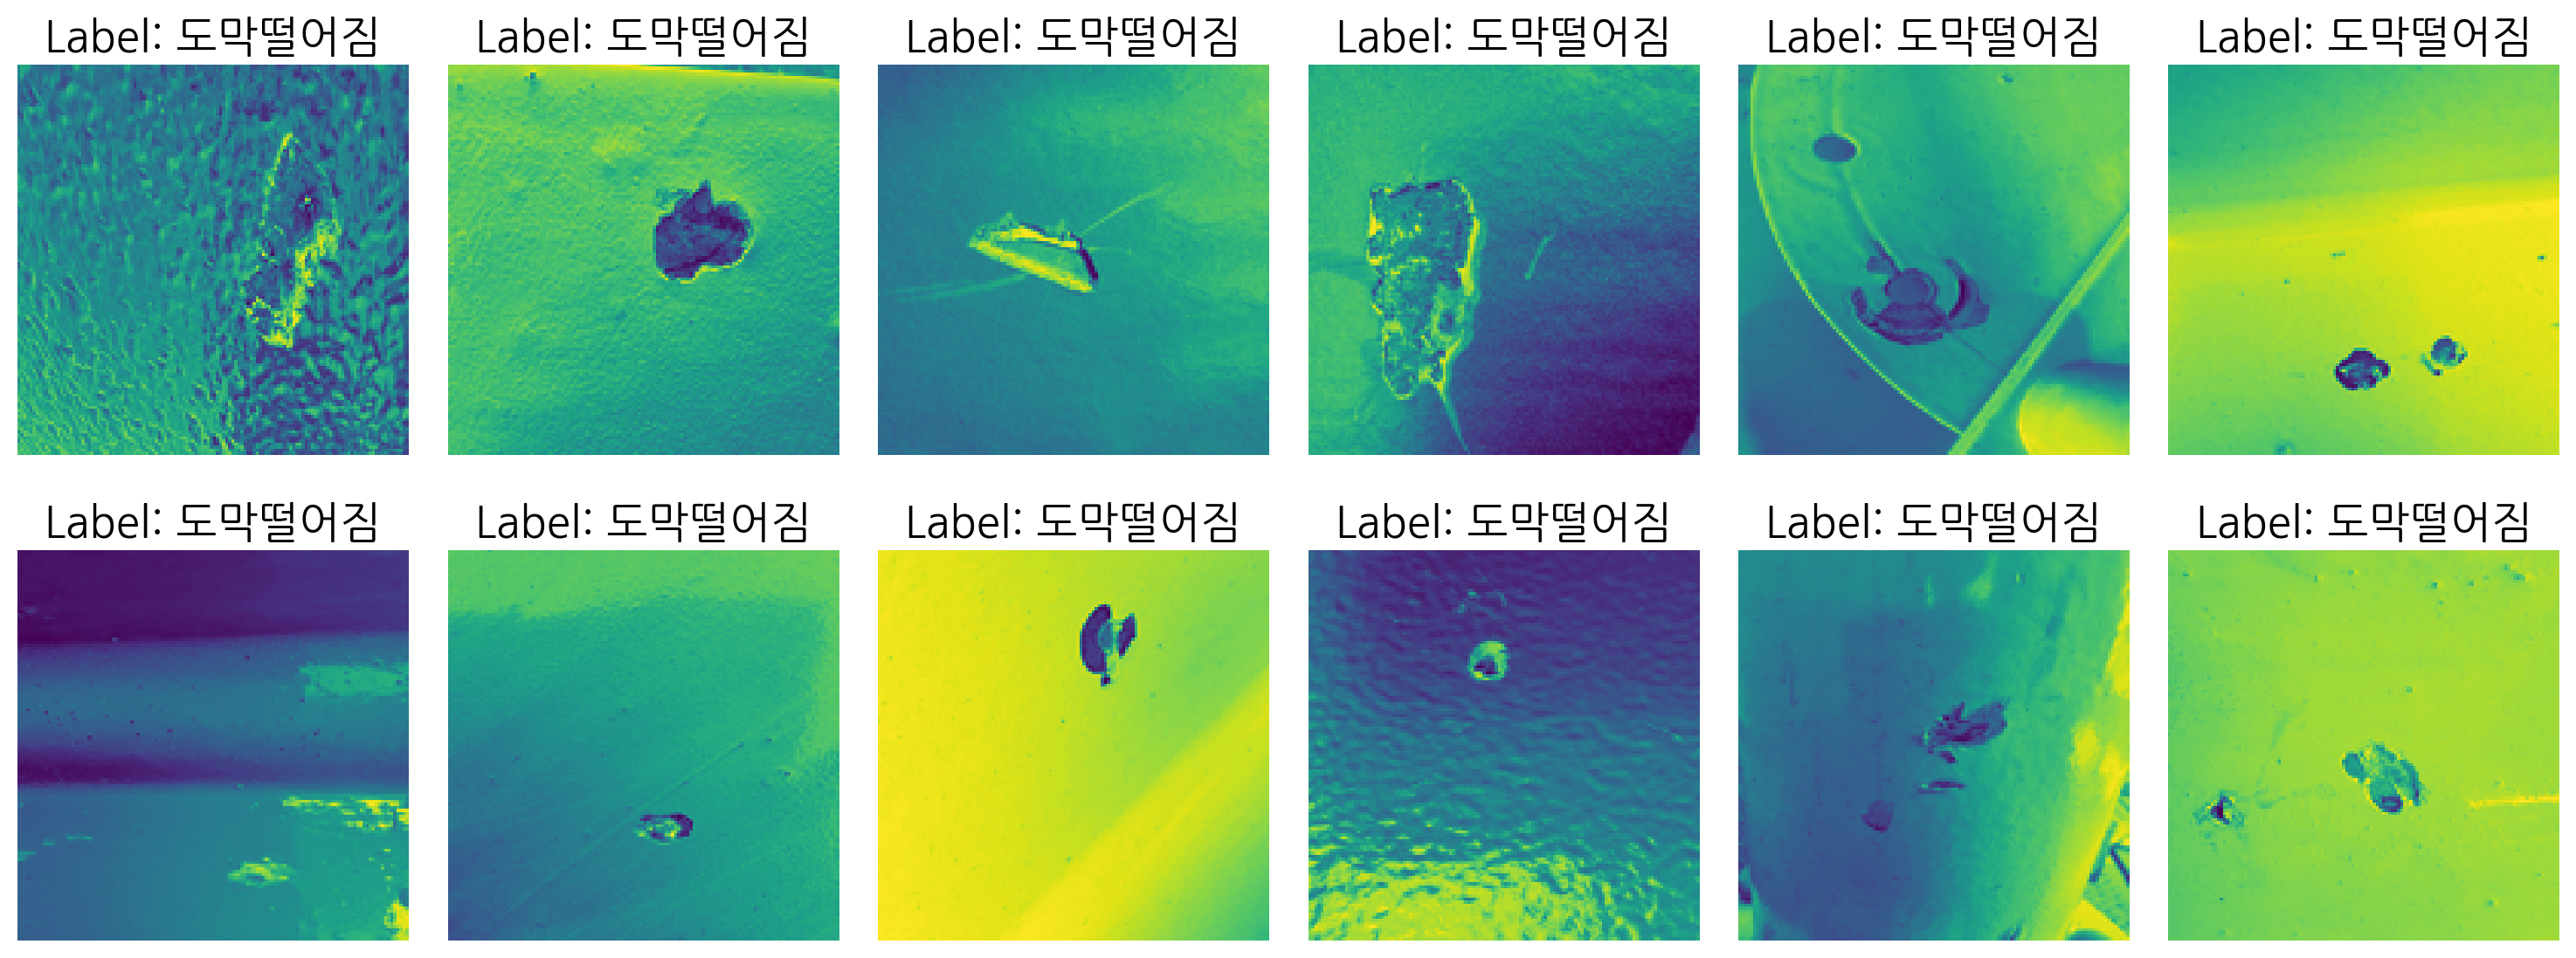

In [13]:
# 이미지 및 라벨 확인
plt.rcParams['font.size'] = 15
plt.figure(figsize=(15, 6))  # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 2행 6열로 서브플롯 배치

# 12개의 이미지 출력 (X와 y의 길이가 12라고 가정)
for idx, (image_data, label) in enumerate(zip(X[500:512], y[500:512])):
    ax = plt.subplot(grid[idx])
    ax.imshow(image_data)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # 축 정보 숨기기

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

### 훈련 데이터, 검증 데이터 분리

In [14]:
# X는 (128, 128) 넘파이 배열들의 리스트, y는 라벨들의 리스트입니다.
# 훈련 데이터, 검증 데이터 분리

train_X, valid_X, train_y, valid_y = train_test_split(X, y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=50)

In [15]:
print('훈련 데이터 개수:', len(train_X))
print('검증 데이터 개수:', len(valid_X))

훈련 데이터 개수: 1080
검증 데이터 개수: 120


### 데이터셋 클래스 정의

In [16]:
from torch.utils.data import Dataset

# 파이토치 Dataset 클래스
class ImageDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        if self.y is not None:
            # 리스트에서 직접 이미지와 라벨 가져오기
            image = self.X[idx]
            label = self.y[idx]
            
            # transform이 있다면 변환 적용
            if self.transform is not None:
                image = self.transform(image)
            
            # PyTorch CNN 모델 학습을 위해 라벨을 숫자로 매핑 (예시)
            # 실제 라벨에 맞춰 매핑 코드를 작성해야 합니다.
            label_map = {'양품': 0, '스크래치': 1, '부풀음': 2, '도막떨어짐':3, '이물질포함':4}
            label_tensor = torch.tensor(label_map[label], dtype=torch.long)
            
            return image, label_tensor
        
        else:
            # 추론 과정에서 라벨이 없을 때 사용
            image = self.X[idx]

            # transform이 있다면 변환 적용
            if self.transform is not None:
                image = self.transform(image)
                
            return image

### 이미지 변환기 정의 - Data Augmentation

In [17]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(128, padding_mode='symmetric'), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize(mean=[0.5], std=[0.5])])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(128, padding_mode='symmetric'),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])

### 데이터셋 및 데이터 로더 생성

In [18]:
# Dataset 객체 생성
dataset_train = ImageDataset(X=train_X, y=train_y, transform=transform_train)
dataset_valid = ImageDataset(X=valid_X, y=valid_y, transform=transform_test)

In [19]:
# 데이터로드 시 병렬 처리를 위한 시드 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [20]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

In [21]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 3 * 3, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=5)

    # 순전파 출력 정의 
    def forward(self, x):    # x.shape - (32, 1, 384, 384) - 384 = 128*3(데이터 증강 과정에서)
        x = self.layer1(x)    # x.shape - (32, 32, 193, 193)
        x = self.layer2(x)    # x.shape - (32, 64, 97, 97)
        x = self.layer3(x)    # x.shape - (32, 128, 49, 49)
        x = self.layer4(x)    # x.shape - (32, 256, 25, 25)
        x = self.layer5(x)    # x.shape - (32, 512, 13, 13)
        x = self.avg_pool(x)   # x.shape - (32, 512, 3, 3)
        x = x.view(-1, 512 * 3 * 3) # 평탄화 (32, 512 * 3 * 3)
        x = self.fc1(x)          # (32, 64)
        x = self.fc2(x)          # (32, 5)
        return x

In [22]:
model = Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128,

## 모델 훈련

### 손실 함수와 옵티마이저 설정

In [23]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [24]:
# 옵티마이저
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

### 스케줄러 설정

In [25]:
from transformers import get_cosine_schedule_with_warmup

epochs = 39 # 총 에폭

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*3, 
                                            num_training_steps=len(loader_train)*epochs)

### 모델 훈련

In [26]:
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.argmax(outputs.cpu(), dim=1).numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 정밀도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_precision = precision_score(true_list, preds_list, average='macro')
        val_recall = recall_score(true_list, preds_list, average='macro')
        val_f1_score = f1_score(true_list, preds_list, average='macro')

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [27]:
# 모델 훈련
model_state_dict = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer,
                         scheduler=scheduler,
                         epochs=epochs)

# 모델에 최적 가중치 적용
model.load_state_dict(model_state_dict)

에폭 [1/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 1.4456
	검증 데이터 손실값 : 1.4665
	정확도 : 0.3333 / 재현율 : 0.2000 / F1 점수 : 0.1000
	### 검증 데이터 손실값 감소 (inf --> 5.8661). 모델 저장
에폭 [2/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 1.0007
	검증 데이터 손실값 : 0.7980
	정확도 : 0.7250 / 재현율 : 0.6700 / F1 점수 : 0.6500
	### 검증 데이터 손실값 감소 (5.8661 --> 3.1920). 모델 저장
에폭 [3/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.6540
	검증 데이터 손실값 : 0.4594
	정확도 : 0.9167 / 재현율 : 0.9000 / F1 점수 : 0.9010
	### 검증 데이터 손실값 감소 (3.1920 --> 1.8374). 모델 저장
에폭 [4/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.4682
	검증 데이터 손실값 : 0.2778
	정확도 : 0.9333 / 재현율 : 0.9200 / F1 점수 : 0.9203
	### 검증 데이터 손실값 감소 (1.8374 --> 1.1113). 모델 저장
에폭 [5/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3526
	검증 데이터 손실값 : 0.2910
	정확도 : 0.9083 / 재현율 : 0.8900 / F1 점수 : 0.8921
에폭 [6/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3265
	검증 데이터 손실값 : 0.2128
	정확도 : 0.9500 / 재현율 : 0.9400 / F1 점수 : 0.9393
	### 검증 데이터 손실값 감소 (1.1113 --> 0.8511). 모델 저장
에폭 [7/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2885
	검증 데이터 손실값 : 0.1627
	정확도 : 0.9500 / 재현율 : 0.9400 / F1 점수 : 0.9384
	### 검증 데이터 손실값 감소 (0.8511 --> 0.6508). 모델 저장
에폭 [8/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2552
	검증 데이터 손실값 : 0.1468
	정확도 : 0.9417 / 재현율 : 0.9300 / F1 점수 : 0.9316
	### 검증 데이터 손실값 감소 (0.6508 --> 0.5870). 모델 저장
에폭 [9/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2507
	검증 데이터 손실값 : 0.1111
	정확도 : 0.9750 / 재현율 : 0.9700 / F1 점수 : 0.9700
	### 검증 데이터 손실값 감소 (0.5870 --> 0.4446). 모델 저장
에폭 [10/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2457
	검증 데이터 손실값 : 0.0972
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
	### 검증 데이터 손실값 감소 (0.4446 --> 0.3888). 모델 저장
에폭 [11/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2273
	검증 데이터 손실값 : 0.1006
	정확도 : 0.9667 / 재현율 : 0.9600 / F1 점수 : 0.9599
에폭 [12/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1996
	검증 데이터 손실값 : 0.1805
	정확도 : 0.9167 / 재현율 : 0.9000 / F1 점수 : 0.9076
에폭 [13/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1950
	검증 데이터 손실값 : 0.1072
	정확도 : 0.9750 / 재현율 : 0.9700 / F1 점수 : 0.9740
에폭 [14/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1978
	검증 데이터 손실값 : 0.0967
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
	### 검증 데이터 손실값 감소 (0.3888 --> 0.3869). 모델 저장
에폭 [15/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1699
	검증 데이터 손실값 : 0.0790
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
	### 검증 데이터 손실값 감소 (0.3869 --> 0.3158). 모델 저장
에폭 [16/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1687
	검증 데이터 손실값 : 0.3091
	정확도 : 0.9083 / 재현율 : 0.8950 / F1 점수 : 0.8994
에폭 [17/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1515
	검증 데이터 손실값 : 0.0746
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
	### 검증 데이터 손실값 감소 (0.3158 --> 0.2982). 모델 저장
에폭 [18/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1553
	검증 데이터 손실값 : 0.0633
	정확도 : 0.9750 / 재현율 : 0.9700 / F1 점수 : 0.9698
	### 검증 데이터 손실값 감소 (0.2982 --> 0.2531). 모델 저장
에폭 [19/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1685
	검증 데이터 손실값 : 0.0613
	정확도 : 0.9917 / 재현율 : 0.9900 / F1 점수 : 0.9900
	### 검증 데이터 손실값 감소 (0.2531 --> 0.2451). 모델 저장
에폭 [20/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1458
	검증 데이터 손실값 : 0.0651
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
에폭 [21/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1382
	검증 데이터 손실값 : 0.0809
	정확도 : 0.9667 / 재현율 : 0.9600 / F1 점수 : 0.9596
에폭 [22/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1371
	검증 데이터 손실값 : 0.0696
	정확도 : 0.9750 / 재현율 : 0.9700 / F1 점수 : 0.9698
에폭 [23/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1413
	검증 데이터 손실값 : 0.0497
	정확도 : 0.9917 / 재현율 : 0.9900 / F1 점수 : 0.9900
	### 검증 데이터 손실값 감소 (0.2451 --> 0.1989). 모델 저장
에폭 [24/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1219
	검증 데이터 손실값 : 0.0530
	정확도 : 0.9917 / 재현율 : 0.9900 / F1 점수 : 0.9900
에폭 [25/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1127
	검증 데이터 손실값 : 0.0599
	정확도 : 0.9750 / 재현율 : 0.9700 / F1 점수 : 0.9698
에폭 [26/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1059
	검증 데이터 손실값 : 0.0488
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1989 --> 0.1953). 모델 저장
에폭 [27/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1089
	검증 데이터 손실값 : 0.0516
	정확도 : 0.9917 / 재현율 : 0.9900 / F1 점수 : 0.9900
에폭 [28/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0971
	검증 데이터 손실값 : 0.0446
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1953 --> 0.1783). 모델 저장
에폭 [29/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0977
	검증 데이터 손실값 : 0.0446
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [30/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1052
	검증 데이터 손실값 : 0.0485
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
에폭 [31/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0899
	검증 데이터 손실값 : 0.0488
	정확도 : 0.9917 / 재현율 : 0.9900 / F1 점수 : 0.9900
에폭 [32/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0970
	검증 데이터 손실값 : 0.0482
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
에폭 [33/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0914
	검증 데이터 손실값 : 0.0450
	정확도 : 0.9833 / 재현율 : 0.9800 / F1 점수 : 0.9799
에폭 [34/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0932
	검증 데이터 손실값 : 0.0463
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [35/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0896
	검증 데이터 손실값 : 0.0458
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [36/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0891
	검증 데이터 손실값 : 0.0436
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1783 --> 0.1746). 모델 저장
에폭 [37/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0906
	검증 데이터 손실값 : 0.0443
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [38/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0923
	검증 데이터 손실값 : 0.0437
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [39/39] 
-----------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0903
	검증 데이터 손실값 : 0.0469
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000


<All keys matched successfully>

## 제출 점수
Public Score : 0.8877167378911908

## 예측 및 결과 제출

In [28]:
ROOT = Path("/mnt/elice/dataset")
SUBMIT_DIR = ROOT / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (128, 128)

In [29]:
filenames, labels = [], []
X_sub = []
for p in SUBMIT_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        im = Image.open(p).convert("L").resize(IMG_SIZE)
        x = np.array(im, dtype=np.float32) / 255.0
        X_sub.append(x)
#         y_pred = clf.predict(x)
#         label_ko = le.inverse_transform(y_pred)[0]  # 한글 라벨 복원
        filenames.append(p.name)  # 인덱스는 파일명(문자열)
#         labels.append(label_ko)

In [30]:
# Dataset 객체 생성
dataset_test = ImageDataset(X=X_sub, transform=transform_test)

# DataLoader 객체 생성
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

### 추론

In [33]:
def predict(model, loader_test):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images in loader_test:
            images = images.to(device)
            
            outputs = model(images)
            
            preds = torch.argmax(outputs.cpu(), dim=1).numpy() # 예측값

            preds_list.extend(preds)

    return preds_list

In [34]:
preds_list = predict(model=model, 
                      loader_test=loader_test)

In [35]:
label_dict = {'양품': 0, '스크래치': 1, '부풀음': 2, '도막떨어짐':3, '이물질포함':4}
reverse_label_map = {v: k for k, v in label_dict.items()}
preds_labels = [reverse_label_map[pred] for pred in preds_list]
# preds_labels

In [36]:
# 제출을 위한 데이터프레임 만들기
df_submit = pd.DataFrame({"label": preds_labels}, index=filenames)
df_submit = df_submit.sort_index() 
df_submit.to_csv("./submission.csv", encoding="utf-8")  # 현재 작업 디렉토리에 저장

df_submit.head()

,label
00001.jpg,도막떨어짐
00002.jpg,도막떨어짐
00003.jpg,스크래치
00004.jpg,스크래치
00005.jpg,양품


### 예측값 분포 확인

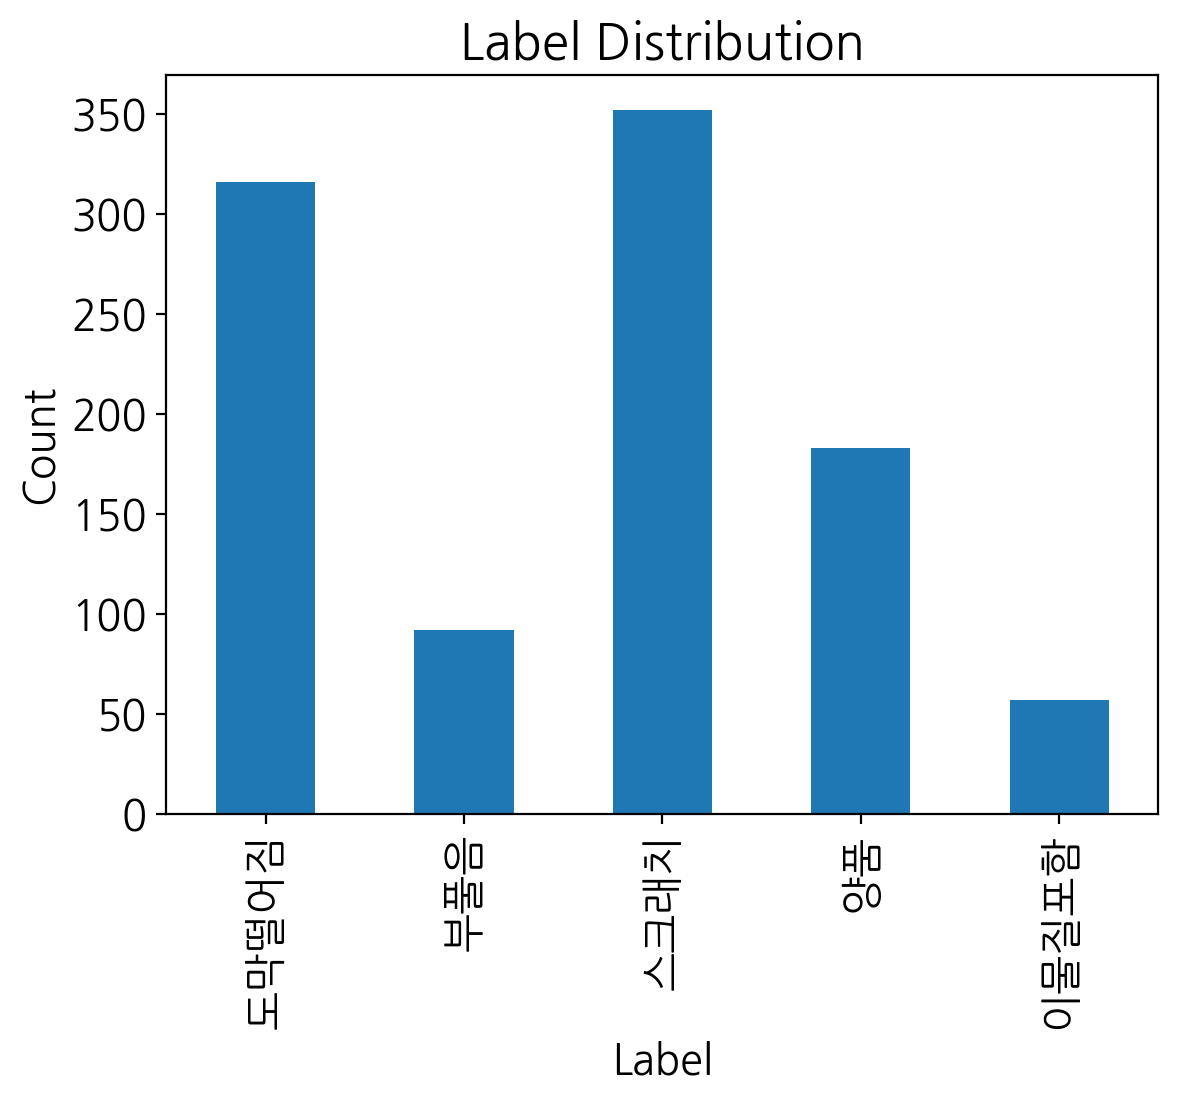

In [37]:
df_submit['label'].value_counts().sort_index().plot(kind='bar')

# 히스토그램 제목과 축 레이블 설정
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()